# Retail Banking — Data Cleaning, EDA, and RFM Segmentation

**Objective:** Prepare transaction data for customer insights and segmentation.

**Workflow:**
1. **Data Ingestion** — Load raw data and inspect schema
2. **Data Cleaning** — Fix dates, times, types, and check duplicates
3. **Exploratory Data Analysis** — Understand distributions, outliers, patterns
4. **RFM Segmentation** — Build customer scores and segments
5. **Save Outputs** — Export clean data for modeling/dashboards


---
## 1. Data Ingestion


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
pd.options.display.float_format = '{:.2f}'.format


In [18]:
# Load raw data
data = pd.read_csv("../data/bank_data_C.csv")
print(f"Loaded {len(data):,} rows")
data.head()


Loaded 1,041,614 rows


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50


**Schema check:** Confirm columns match the data dictionary from the instructions.


In [19]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041614 entries, 0 to 1041613
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041614 non-null  object 
 1   CustomerID               1041614 non-null  object 
 2   CustomerDOB              1041614 non-null  object 
 3   CustGender               1041614 non-null  object 
 4   CustLocation             1041614 non-null  object 
 5   CustAccountBalance       1041614 non-null  float64
 6   TransactionDate          1041614 non-null  object 
 7   TransactionTime          1041614 non-null  int64  
 8   TransactionAmount (INR)  1041614 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 71.5+ MB


---
## 2. Data Cleaning

We'll systematically clean:
- Column names (remove units like "(INR)")
- Dates (parse day-first format, fix 2-digit year issues)
- Time fields (parse HHMMSS format)
- Duplicates (ensure unique transactions)


### 2.1 Rename columns


In [20]:
data = data.rename(columns={"TransactionAmount (INR)": "TransactionAmount"})
list(data.columns)


['TransactionID',
 'CustomerID',
 'CustomerDOB',
 'CustGender',
 'CustLocation',
 'CustAccountBalance',
 'TransactionDate',
 'TransactionTime',
 'TransactionAmount']

### 2.2 Parse dates

**Why:** Dates like `10/1/94` are ambiguous—pandas might misinterpret them. We normalize to `DD/MM/YY` first, then parse with an explicit format.


In [21]:
def normalize_dmy(x):
    """Normalize day-first dates to DD/MM/YY format."""
    if pd.isna(x): return np.nan
    try:
        d, m, y = str(x).strip().split('/')
        return f"{int(d):02d}/{int(m):02d}/{int(y):02d}"
    except:
        return np.nan

for col in ["CustomerDOB", "TransactionDate"]:
    data[col] = data[col].map(normalize_dmy)
    data[col] = pd.to_datetime(data[col], format="%d/%m/%y", errors="coerce")

data[["CustomerDOB", "TransactionDate"]].head()


,CustomerDOB,TransactionDate
0,1994-01-10,2016-08-02
1,2057-04-04,2016-08-02
2,1996-11-26,2016-08-02
3,1973-09-14,2016-08-02
4,1988-03-24,2016-08-02


### 2.3 Fix future DOBs

**Issue:** Two-digit year parsing assumes `00-68 → 2000-2068` and `69-99 → 1969-1999`. This creates future DOBs like `2057`.

**Fix:** Subtract 100 years from any DOB > today.


In [22]:
from pandas.tseries.offsets import DateOffset

mask = data["CustomerDOB"] > pd.Timestamp.today()
data.loc[mask, "CustomerDOB"] -= DateOffset(years=100)
print(f"✅ Fixed {mask.sum()} future DOBs")
data[["CustomerDOB"]].head(10)


✅ Fixed 54111 future DOBs


,CustomerDOB
0,1994-01-10
1,1957-04-04
2,1996-11-26
3,1973-09-14
4,1988-03-24
5,1972-10-08
6,1992-01-26
7,1982-01-27
8,1988-04-19
9,1984-06-22


### 2.4 Parse transaction time

**Why:** Combine date + time for accurate temporal analysis (e.g., hourly patterns).


In [23]:
tt = data["TransactionTime"].astype(str).str.zfill(6)  # Pad to HHMMSS
data["TransactionDateTime"] = pd.to_datetime(
    data["TransactionDate"].dt.strftime("%Y-%m-%d") + " " + tt,
    format="%Y-%m-%d %H%M%S", errors="coerce"
)
print(f"Datetime nulls: {data['TransactionDateTime'].isna().sum()}")
data[["TransactionDate", "TransactionTime", "TransactionDateTime"]].head()


Datetime nulls: 0


,TransactionDate,TransactionTime,TransactionDateTime
0,2016-08-02,143207,2016-08-02 14:32:07
1,2016-08-02,141858,2016-08-02 14:18:58
2,2016-08-02,142712,2016-08-02 14:27:12
3,2016-08-02,142714,2016-08-02 14:27:14
4,2016-08-02,181156,2016-08-02 18:11:56


### 2.5 Duplicate check


In [24]:
exact_dups = data.duplicated().sum()
txid_dups = data["TransactionID"].duplicated().sum()
print(f"Exact duplicates: {exact_dups}")
print(f"Duplicate TransactionIDs: {txid_dups}")


Exact duplicates: 0
Duplicate TransactionIDs: 0


**Result:** No duplicates found → all rows are unique transactions.


---
## 3. Exploratory Data Analysis (EDA)


### 3.1 Summary statistics


In [25]:
summary = {
    "Total Rows": len(data),
    "Unique Customers": data["CustomerID"].nunique(),
    "Date Range": f"{data['TransactionDate'].min().date()} to {data['TransactionDate'].max().date()}",
    "Missing DOB": data["CustomerDOB"].isna().sum()
}
pd.Series(summary)


Total Rows                           1041614
Unique Customers                      879358
Date Range          2016-08-01 to 2016-10-21
Missing DOB                            56292
dtype: object

In [26]:
data[["TransactionAmount", "CustAccountBalance"]].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
TransactionAmount,1041614.00,1566.10,6561.46,0.00,8.00,30.00,160.00,457.50,1200.00,5176.00,20000.00,1560034.99
CustAccountBalance,1041614.00,114998.61,846760.94,0.00,3.35,70.15,4728.14,16768.52,57428.85,414522.23,1586508.61,115035495.10


**Key Observations:**
- ~880k unique customers, 1.04M transactions over ~2.5 months (Aug–Oct 2016)
- **Heavy right skew:** Max >> 99th percentile for both amount and balance
  - TransactionAmount: max = 1.56M vs 99th = 20K
  - CustAccountBalance: max = 115M vs 99th = 1.59M
- This suggests **extreme outliers** that could dominate plots and distort insights


### 3.2 Outlier Detection

We'll use **two methods** to detect outliers:

#### Method 1: IQR (Interquartile Range)
- Calculate Q1 (25th percentile) and Q3 (75th percentile)
- IQR = Q3 - Q1
- Outliers are values < Q1 - 1.5×IQR or > Q3 + 1.5×IQR
- **Pro:** Standard statistical method, robust to extreme values
- **Con:** Can flag too many points in skewed distributions

#### Method 2: Percentile thresholds
- Flag values below 1st percentile or above 99th percentile
- **Pro:** Simple, controls outlier proportion (keeps 98% of data)
- **Con:** Arbitrary cutoffs


In [27]:
# Method 1: IQR-based outlier detection
def iqr_outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return lower, upper, (series < lower).sum(), (series > upper).sum()

print("=== IQR Method ===")
for col in ["TransactionAmount", "CustAccountBalance"]:
    lower, upper, n_low, n_high = iqr_outliers(data[col].dropna())
    pct_outliers = 100 * (n_low + n_high) / len(data)
    print(f"\n{col}:")
    print(f"  IQR bounds: [{lower:,.2f}, {upper:,.2f}]")
    print(f"  Outliers: {n_low} below, {n_high} above ({pct_outliers:.1f}% total)")


=== IQR Method ===

TransactionAmount:
  IQR bounds: [-1,400.00, 2,760.00]
  Outliers: 0 below, 110614 above (10.6% total)

CustAccountBalance:
  IQR bounds: [-74,322.93, 136,479.92]
  Outliers: 0 below, 140263 above (13.5% total)


In [28]:
# Method 2: Percentile-based outlier detection
print("\n=== Percentile Method (1% / 99%) ===")
for col in ["TransactionAmount", "CustAccountBalance"]:
    p1, p99 = data[col].quantile([0.01, 0.99])
    n_below = (data[col] < p1).sum()
    n_above = (data[col] > p99).sum()
    print(f"\n{col}:")
    print(f"  1st percentile: {p1:,.2f}")
    print(f"  99th percentile: {p99:,.2f}")
    print(f"  Outliers: {n_below} below, {n_above} above (2% by definition)")



=== Percentile Method (1% / 99%) ===

TransactionAmount:
  1st percentile: 8.00
  99th percentile: 20,000.00
  Outliers: 10112 below, 9976 above (2% by definition)

CustAccountBalance:
  1st percentile: 3.35
  99th percentile: 1,586,508.61
  Outliers: 10416 below, 10386 above (2% by definition)


### 3.3 Decision: Capping Strategy

**Problem:** Outliers will dominate visualizations (e.g., histograms compressed to the left, scatter plots unreadable).

**Solution:** Create a **capped copy for visualizations only**
- Cap at **1st and 99th percentiles**
- **Keep raw data intact** for modeling (algorithms like Random Forest handle outliers well)
- This balances **visual clarity** with **data integrity**

**Why 1%/99% instead of IQR?**
- IQR flags 10-13% of data as outliers (too aggressive for skewed banking data)
- 1%/99% keeps 98% of observations, improving plot readability while retaining most variation


In [29]:
# Create capped copy for plotting ONLY
eda = data.copy()
for col in ["TransactionAmount", "CustAccountBalance"]:
    lower, upper = eda[col].quantile([0.01, 0.99])
    eda[col] = eda[col].clip(lower, upper)

print("✅ Created capped copy 'eda' for visualizations")
print("✅ Original 'data' remains unchanged for modeling")
eda[["TransactionAmount", "CustAccountBalance"]].describe().T


✅ Created capped copy 'eda' for visualizations
✅ Original 'data' remains unchanged for modeling


,count,mean,std,min,25%,50%,75%,max
TransactionAmount,1041614.00,1317.25,2781.44,8.00,160.00,457.50,1200.00,20000.00
CustAccountBalance,1041614.00,86854.65,223902.03,3.35,4728.14,16768.52,57428.85,1586508.61


### 3.4 Distribution plots


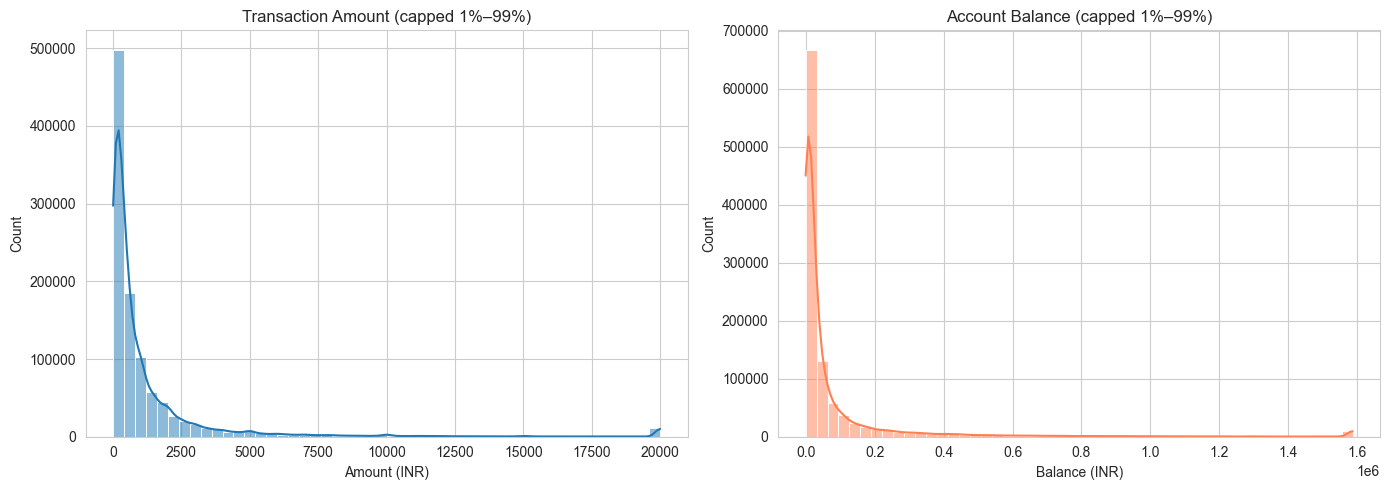

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(eda["TransactionAmount"], kde=True, ax=axes[0], bins=50)
axes[0].set_title("Transaction Amount (capped 1%–99%)")
axes[0].set_xlabel("Amount (INR)")
sns.histplot(eda["CustAccountBalance"], kde=True, ax=axes[1], bins=50, color="coral")
axes[1].set_title("Account Balance (capped 1%–99%)")
axes[1].set_xlabel("Balance (INR)")
plt.tight_layout()
plt.show()


**Insights:**
- Both distributions remain **right-skewed** even after capping
- Most transactions are small (mode ~₹500); most balances are low-to-mid range
- Long tail suggests a **small group of high-value customers** drives large monetary volume


### 3.5 Categorical analysis — Gender and Location


In [31]:
print("Gender distribution:")
print(data["CustGender"].value_counts())
print(f"\nPercentage Male: {100*data['CustGender'].value_counts(normalize=True)['M']:.1f}%")
print("\nTop 10 locations:")
print(data["CustLocation"].value_counts().head(10))


Gender distribution:
CustGender
M    760978
F    280635
T         1
Name: count, dtype: int64

Percentage Male: 73.1%

Top 10 locations:
CustLocation
MUMBAI       101997
NEW DELHI     84143
BANGALORE     81330
GURGAON       73594
DELHI         70549
NOIDA         32656
CHENNAI       29840
PUNE          25690
HYDERABAD     22976
THANE         21397
Name: count, dtype: int64


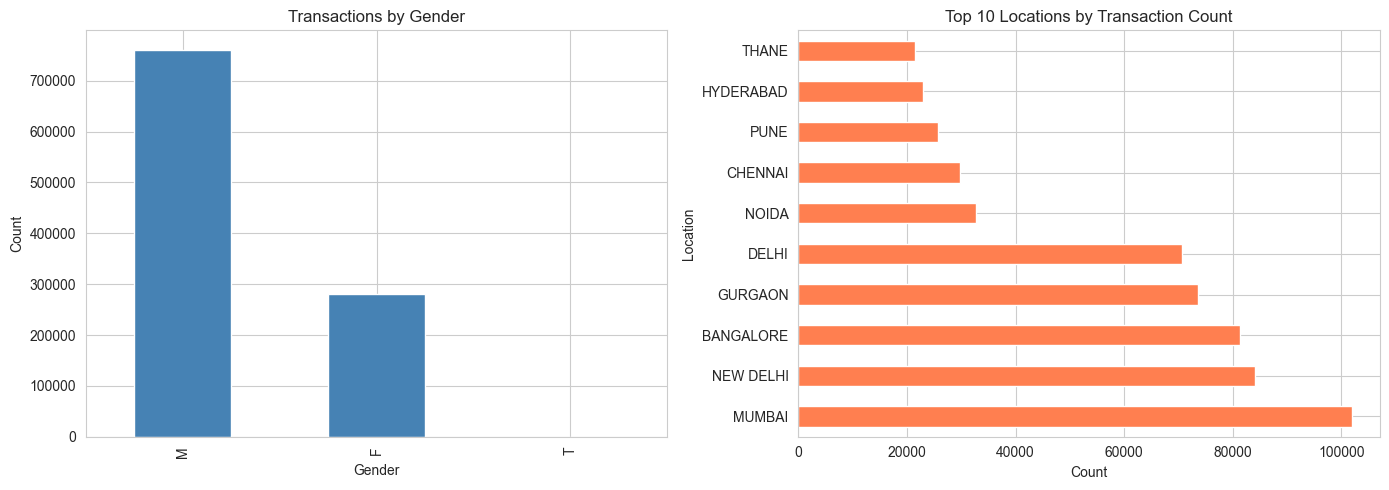

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
data["CustGender"].value_counts().plot.bar(ax=axes[0], color="steelblue")
axes[0].set_title("Transactions by Gender")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Gender")

data["CustLocation"].value_counts().head(10).plot.barh(ax=axes[1], color="coral")
axes[1].set_title("Top 10 Locations by Transaction Count")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Location")
plt.tight_layout()
plt.show()


**Insights:**
- **Male-dominated:** ~73% of transactions are from male customers
- **Urban concentration:** Top 3 cities (Mumbai, New Delhi, Bangalore) account for ~25% of transactions
- **Geographic targeting opportunity:** Focus marketing in tier-1 cities where volume is highest


### 3.6 Monthly trends


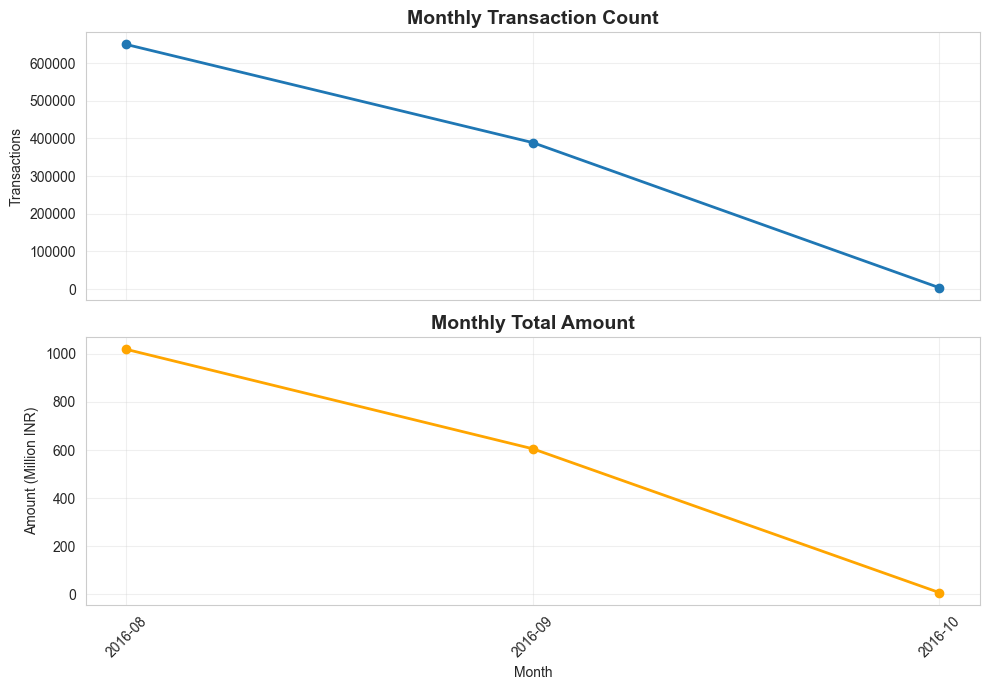

,YearMonth,tx_count,total_amount
0,2016-08,649243,1018462195.30
1,2016-09,388727,605180800.35
2,2016-10,3644,7624606.07


In [33]:
data["YearMonth"] = data["TransactionDate"].dt.to_period("M").astype(str)
monthly = data.groupby("YearMonth").agg(
    tx_count=("TransactionID", "count"),
    total_amount=("TransactionAmount", "sum")
).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
axes[0].plot(monthly["YearMonth"], monthly["tx_count"], marker="o", linewidth=2)
axes[0].set_title("Monthly Transaction Count", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Transactions")
axes[0].grid(True, alpha=0.3)

axes[1].plot(monthly["YearMonth"], monthly["total_amount"]/1e6, marker="o", color="orange", linewidth=2)
axes[1].set_title("Monthly Total Amount", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Amount (Million INR)")
axes[1].set_xlabel("Month")
axes[1].grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly


**Insights:**
- **Declining trend:** Both transaction volume and amount decline sharply from August to October
- August had ~650K transactions, October had only ~3.6K
- **Possible explanations:**
  - Data collection window (August = full month, October = partial)
  - Seasonal effect (post-festival slowdown)
  - Data quality issue (missing October data)


---
## 4. RFM Segmentation

**RFM** = Recency, Frequency, Monetary
- **Recency:** How recently did the customer transact? (lower = better → recent customers are engaged)
- **Frequency:** How often do they transact? (higher = better → frequent buyers are loyal)
- **Monetary:** How much do they spend? (higher = better → high spenders are valuable)


### 4.1 Compute RFM features


In [34]:
snapshot_date = data["TransactionDate"].max() + pd.Timedelta(days=1)

rfm = data.groupby("CustomerID").agg(
    recency_days=("TransactionDate", lambda x: (snapshot_date - x.max()).days),
    frequency=("TransactionID", "count"),
    monetary=("TransactionAmount", "sum")
).reset_index()

print(f"RFM table: {len(rfm):,} customers")
rfm.head(10)


RFM table: 879,358 customers


,CustomerID,recency_days,frequency,monetary
0,C1010011,26,2,5106.00
1,C1010012,69,1,1499.00
2,C1010014,76,2,1455.00
3,C1010018,37,1,30.00
4,C1010024,65,1,5000.00
5,C1010028,54,1,557.00
6,C1010031,79,2,1864.00
7,C1010035,56,2,750.00
8,C1010036,57,1,208.00
9,C1010037,74,1,19680.00


### 4.2 Assign RFM scores (quintiles 1–5)

We score each metric using **quantiles** (divide customers into 5 equal groups):
- **R score:** 5 = most recent, 1 = least recent (inverted because lower recency days = better)
- **F score:** 5 = most frequent, 1 = least frequent
- **M score:** 5 = highest spender, 1 = lowest spender


In [35]:
rfm["R_score"] = pd.qcut(rfm["recency_days"].rank(method="first"), 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_score"] = pd.qcut(rfm["monetary"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)

rfm["RFM_score"] = rfm["R_score"].astype(str) + rfm["F_score"].astype(str) + rfm["M_score"].astype(str)

rfm.head(10)


,CustomerID,recency_days,frequency,monetary,R_score,F_score,M_score,RFM_score
0,C1010011,26,2,5106.00,5,5,5,555
1,C1010012,69,1,1499.00,2,1,4,214
2,C1010014,76,2,1455.00,1,5,4,154
3,C1010018,37,1,30.00,5,1,1,511
4,C1010024,65,1,5000.00,2,1,5,215
5,C1010028,54,1,557.00,3,1,3,313
6,C1010031,79,2,1864.00,1,5,4,154
7,C1010035,56,2,750.00,3,5,3,353
8,C1010036,57,1,208.00,3,1,2,312
9,C1010037,74,1,19680.00,1,1,5,115


### 4.3 Map scores to business segments


In [36]:
def assign_segment(row):
    r, f, m = row["R_score"], row["F_score"], row["M_score"]
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    if r >= 4 and f >= 3:
        return "Loyal"
    if r >= 3 and f >= 2 and m >= 3:
        return "Potential Loyalists"
    if r <= 2 and f <= 2 and m <= 2:
        return "At Risk"
    if r <= 2 and f >= 4:
        return "Need Attention"
    return "Others"

rfm["segment"] = rfm.apply(assign_segment, axis=1)

rfm["segment"].value_counts()


segment
Others                 350347
Loyal                  138260
Need Attention         119257
Potential Loyalists    118111
Champions               85382
At Risk                 68001
Name: count, dtype: int64

### 4.4 Segment profiles


In [37]:
profiles = rfm.groupby("segment").agg(
    customers=("CustomerID", "count"),
    avg_recency=("recency_days", "mean"),
    avg_frequency=("frequency", "mean"),
    avg_monetary=("monetary", "mean")
).round(2).sort_values("customers", ascending=False)

profiles


,customers,avg_recency,avg_frequency,avg_monetary
segment,,,,
Others,350347,59.69,1.01,1491.94
Loyal,138260,40.83,1.21,893.01
Need Attention,119257,71.30,1.23,1967.21
Potential Loyalists,118111,51.55,1.25,2995.83
Champions,85382,40.50,1.86,4522.60
At Risk,68001,72.20,1.00,154.56


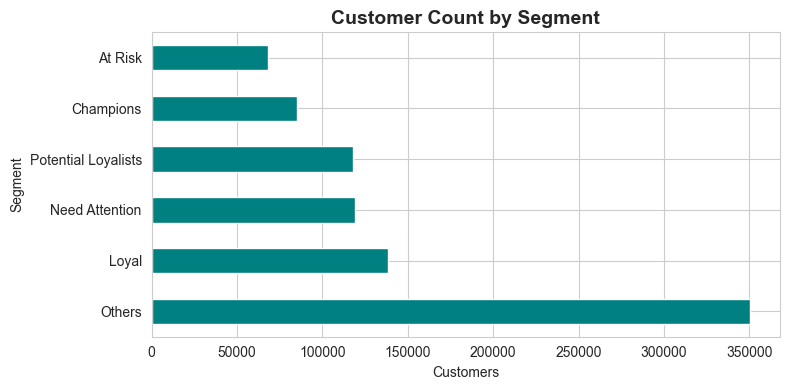

In [38]:
profiles["customers"].plot.barh(figsize=(8, 4), color="teal")
plt.title("Customer Count by Segment", fontsize=14, fontweight="bold")
plt.xlabel("Customers")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()


**Segment Insights:**
- **Champions:** High R, F, M → best customers, prioritize retention
- **Loyal:** Recent + frequent → nurture with loyalty programs
- **Potential Loyalists:** Mid-range → upsell opportunities
- **At Risk:** Low engagement → reactivation campaigns
- **Need Attention:** Used to be frequent, now dormant → win-back offers


---
## 5. Save Outputs


In [39]:
from pathlib import Path

out_dir = Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

data.to_csv(out_dir / "transactions_clean.csv", index=False)
rfm.to_csv(out_dir / "rfm_scores.csv", index=False)

print("✅ Saved:")
print(f"  - transactions_clean.csv ({len(data):,} rows)")
print(f"  - rfm_scores.csv ({len(rfm):,} rows)")


✅ Saved:
  - transactions_clean.csv (1,041,614 rows)
  - rfm_scores.csv (879,358 rows)


---
## Summary

### Data Cleaning
✅ Parsed day-first dates with explicit format  
✅ Fixed 2-digit year DOB issues (subtracted 100 years from future dates)  
✅ Combined date + time into `TransactionDateTime`  
✅ No duplicates found  

### EDA Insights
📊 **Data overview:** ~880k customers, 1.04M transactions (Aug–Oct 2016)  
📊 **Gender:** Male-dominated (73%)  
📊 **Geography:** Mumbai, New Delhi, Bangalore dominate  
📊 **Distributions:** Heavy right skew → extreme outliers present  

### Outlier Handling
🔍 **Detection:** IQR method flags 10–13% as outliers; percentile method flags 2%  
✂️ **Strategy:** Capped at 1%–99% for **visualizations only** (raw data preserved)  
💡 **Rationale:** Balances visual clarity with data integrity for downstream modeling  

### RFM Segmentation
🎯 **Scored** customers on Recency, Frequency, Monetary (quintiles 1–5)  
🎯 **Mapped** to business segments: Champions, Loyal, Potential Loyalists, At Risk, Need Attention, Others  
🎯 **Exported** RFM table for KMeans clustering and Streamlit dashboard  

### Next Steps
1. **KMeans Clustering:** Refine segments using unsupervised learning
2. **Streamlit Dashboard:** Interactive RFM explorer with filters and what-if scenarios
3. **Model Evaluation:** Silhouette score, cluster profiles, business metrics
